In [ ]:
import pandas as pd
import seaborn as sns

from google.cloud import bigquery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
sns.set(
    {
      'figure.figsize' : (15,8)
        }
    )


from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist

import numpy as np

PROJECT_ID='dh-darkstores-live'

def query_to_df(query):
  df = pd.read_gbq(query, project_id=PROJECT_ID, dialect='standard')
  return df 

Authenticated


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_km(k,x,y):
    kmeans = KMeans(n_clusters=k,random_state = 0 , max_iter=10)
    wt_kmeansclus = kmeans.fit(x, sample_weight = y)
    return wt_kmeansclus

def get_elbow_score(wt_kmeansclus,X):

    distortions = []
    inertias = []

    distortions.append(sum(np.min(cdist(X, wt_kmeansclus.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(wt_kmeansclus.inertia_)

    mapping1 = sum(np.min(cdist(X, wt_kmeansclus.cluster_centers_,
                                    'euclidean'), axis=1)) / X.shape[0]
    mapping2 = wt_kmeansclus.inertia_

    return mapping1,mapping2

def get_cluster_centres(wt_kmeansclus):
    centers = wt_kmeansclus.cluster_centers_
    return centers

def evaluate_locations(model,warehouses,metric):

  center = pd.DataFrame(
                         get_cluster_centres(model)
                        )
  eval_locations = pd.concat([warehouses,center],axis=1)
  eval_locations.rename(
      columns = {
          'latitude':'actual_lat',
          'longitude' : 'actual_long',
          0 : 'pred_lat',
          1 : 'pred_long'
      },
      inplace=True
  )
  # handling locations for greater than or lesser than actual locations
  # eval_locations.fillna(value = 0,inplace=True)

  eval_locations[f'off by Distance({metric[0]})'] = get_eucledian_distance(eval_locations,metric[0])
  eval_locations[f'off by Time({metric[1]})'] = get_time(eval_locations,f'off by Distance({metric[0]})',metric[1])
  return eval_locations

def get_score(k, X, y):
    km = get_km(k, X,y)
    y_pred = km.predict(X,sample_weight = y)

    sil = silhouette_score(X, y_pred)
    mapping1,mapping2 = get_elbow_score(km,X)
    db = davies_bouldin_score(X, y_pred)

    cal = calinski_harabasz_score(X, y_pred)
    return k, sil, db,cal,mapping1,mapping2,km

def get_time(pred_locations,column_name,metric='mins'):

  LINEAR_FACTOR = 0.028437168446962473
  SQRT_FACTOR = 7.913045828747439
  CONVERT_TO_MINUTES = 60

  # pred_locations = get_eucledian_distance(pred_locations)

  meters_ = pred_locations[column_name]*1000

  driving_time_seconds = (LINEAR_FACTOR  * meters_) + (SQRT_FACTOR*(meters_**0.5))
  if metric == 'mins':
    return driving_time_seconds/CONVERT_TO_MINUTES
  elif metric == 'seconds':
    return driving_time_seconds

def get_eucledian_distance(df,metric='km'):

  from_long = np.array(df['actual_long'].tolist())
  from_lat = np.array(df['actual_lat'].tolist())
  to_long = np.array(df['pred_long'].tolist())
  to_lat = np.array(df['pred_lat'].tolist())
  D = 111.319 
  if metric == 'km':
    return   D* np.sqrt(
                            (from_long - to_long) ** 2  +  (from_lat - to_lat)**2
                       )
  elif metric == 'm':
    return   D* np.sqrt(
                            (from_long - to_long) ** 2  +  (from_lat - to_lat)**2
                       )*1000

def get_info_within_time(time_limit,cross_join_df,metric):

    within_T_ACTUAL = cross_join_df[cross_join_df[f'off by time({metric[1]}) ACTUAL']<=time_limit]
    within_T_PRED = cross_join_df[cross_join_df[f'off by time({metric[1]}) PRED']<=time_limit]

    return within_T_ACTUAL,within_T_PRED

def get_business_metrics(within_T_ACTUAL,within_T_PRED):

  percentage_difference = (within_T_PRED[['num_customers','num_orders','gmv']].sum()/within_T_ACTUAL[['num_customers','num_orders','gmv']].sum() - 1)*100
  absolute_difference = within_T_PRED[['num_customers','num_orders','gmv']].sum() - within_T_ACTUAL[['num_customers','num_orders','gmv']].sum()

  return {
      'dataframe' : {
             'actual_df' : within_T_ACTUAL,
             'pred_df'   : within_T_PRED,
      },
      '% difference' : percentage_difference,
      'pred - actual difference': absolute_difference
  }

def calculate_metrics(df,eval_locations,metric):

  # eval_locations[f'off by ({metric[1]})'] = get_time(eval_locations)

  # defining keys for cross join
  df['key'] = 1
  eval_locations['key']=1 

  #cross join 
  cross_join_df = pd.merge(
    eval_locations,df,on='key').drop("key",1)[['actual_lat','actual_long','pred_lat','pred_long','lat','long','num_orders','num_items','num_customers','gmv']].copy()

  if cross_join_df.shape[0] == df.shape[0] * eval_locations.shape[0]:

    from_long = np.array(cross_join_df['actual_long'].tolist())
    from_lat = np.array(cross_join_df['actual_lat'].tolist())
    to_long = np.array(cross_join_df['long'].tolist())
    to_lat = np.array(cross_join_df['lat'].tolist())

    ##### calcuting off by Distance/Time ##########

    D = 111.319 
    cross_join_df[f'off by Distance({metric[0]}) ACTUAL'] = D* np.sqrt(
        (from_long - to_long) ** 2  +
          (from_lat - to_lat)**2
          )

    LINEAR_FACTOR = 0.028437168446962473
    SQRT_FACTOR = 7.913045828747439

    haversine_meters = cross_join_df[f'off by Distance({metric[0]}) ACTUAL']*1000

    cross_join_df[f'off by time({metric[1]}) ACTUAL'] = ((LINEAR_FACTOR  * haversine_meters) + (SQRT_FACTOR*(haversine_meters**0.5)))/60


    ##############################################
    from_long = np.array(cross_join_df['pred_long'].tolist())
    from_lat = np.array(cross_join_df['pred_lat'].tolist())
    to_long = np.array(cross_join_df['long'].tolist())
    to_lat = np.array(cross_join_df['lat'].tolist())
    D = 111.319 
    cross_join_df[f'off by Distance({metric[0]}) PRED'] = D* np.sqrt(
        (from_long - to_long) ** 2  +
          (from_lat - to_lat)**2
          )

    LINEAR_FACTOR = 0.028437168446962473
    SQRT_FACTOR = 7.913045828747439

    haversine_meters = cross_join_df[f'off by Distance({metric[0]}) PRED']*1000

    cross_join_df[f'off by time({metric[1]}) PRED'] = ((LINEAR_FACTOR  * haversine_meters) + (SQRT_FACTOR*(haversine_meters**0.5)))/60




    ## categorical labelling

    cross_join_df['actual_label'] = cross_join_df[['actual_lat','actual_long']].apply(lambda row: (row.actual_lat,row.actual_long),axis=1)
    cross_join_df['lat_long'] = cross_join_df[['lat','long']].apply(lambda row: (
                                                                                    np.round(row.lat,6),
                                                                                    np.round(row.long,6)
                                                                                    # row.lat,
                                                                                    # row.long
                                                                                 ),
                                                                                    axis=1)
    cross_join_df['pred_label'] = cross_join_df[['pred_lat','pred_long']].apply(lambda row: (row.pred_lat,row.pred_long),axis=1)

    cross_join_df['actual_code'] = cross_join_df['actual_label'].astype('category')
    cross_join_df['pred_code'] = cross_join_df['pred_label'].astype('category')
    cross_join_df['actual_code'] = cross_join_df['actual_code'].cat.codes
    cross_join_df['pred_code'] = cross_join_df['pred_code'].cat.codes

    return cross_join_df


  else :
    return "Wrong Dimension"


def calculate_metrics_fast(df,eval_locations,metric):

  df['key'] = 1
  eval_locations['key']=1 

  #cross join 
  cross_join_df = pd.merge(
  eval_locations,df,on='key').drop("key",1)[['actual_lat','actual_long','pred_lat','pred_long','lat','long','num_orders','num_items','num_customers','gmv']].copy()

  if cross_join_df.shape[0] == df.shape[0] * eval_locations.shape[0]:

    from_long = np.array(cross_join_df['actual_long'].tolist())
    from_lat = np.array(cross_join_df['actual_lat'].tolist())
    to_long = np.array(cross_join_df['long'].tolist())
    to_lat = np.array(cross_join_df['lat'].tolist())

    ##### calcuting off by Distance/Time ##########

    D = 111.319 
    cross_join_df[f'off by Distance({metric[0]}) ACTUAL'] = D* np.sqrt(
        (from_long - to_long) ** 2  +
          (from_lat - to_lat)**2
          )

    LINEAR_FACTOR = 0.028437168446962473
    SQRT_FACTOR = 7.913045828747439

    haversine_meters = cross_join_df[f'off by Distance({metric[0]}) ACTUAL']*1000

    cross_join_df[f'off by time({metric[1]}) ACTUAL'] = ((LINEAR_FACTOR  * haversine_meters) + (SQRT_FACTOR*(haversine_meters**0.5)))/60


    ##############################################
    from_long = np.array(cross_join_df['pred_long'].tolist())
    from_lat = np.array(cross_join_df['pred_lat'].tolist())
    to_long = np.array(cross_join_df['long'].tolist())
    to_lat = np.array(cross_join_df['lat'].tolist())
    D = 111.319 
    cross_join_df[f'off by Distance({metric[0]}) PRED'] = D* np.sqrt(
        (from_long - to_long) ** 2  +
          (from_lat - to_lat)**2
          )

    LINEAR_FACTOR = 0.028437168446962473
    SQRT_FACTOR = 7.913045828747439

    haversine_meters = cross_join_df[f'off by Distance({metric[0]}) PRED']*1000

    cross_join_df[f'off by time({metric[1]}) PRED'] = ((LINEAR_FACTOR  * haversine_meters) + (SQRT_FACTOR*(haversine_meters**0.5)))/60

    ### categorical labelling


    cross_join_df['actual_lat_long'] = cross_join_df['actual_lat'].astype(str) + ',' + cross_join_df['actual_long'].astype(str)
    cross_join_df['pred_lat_long'] = cross_join_df['pred_lat'].astype(str) + ',' + cross_join_df['pred_long'].astype(str)
    cross_join_df['lat_long'] = np.round(cross_join_df['lat'],6).astype(str) + ',' + np.round(cross_join_df['long'],6).astype(str)


    cross_join_df['actual_code'] = cross_join_df['actual_lat_long'].astype('category')
    cross_join_df['pred_code'] = cross_join_df['pred_lat_long'].astype('category')
    cross_join_df['actual_code'] = cross_join_df['actual_code'].cat.codes
    cross_join_df['pred_code'] = cross_join_df['pred_code'].cat.codes
    
    return cross_join_df

  else :
    return "Wrong Dimension"

def get_latlong(locs):
  lat= []
  long = []
  for loc in locs:
    latitude,longitude = loc.split(',')
    lat.append(np.float(latitude))
    long.append(np.float(longitude))
  return lat,long

#---------------


#----


def generate_feature_metrics(covered_per_actual_store):

  feature_columns = ['filtered_loc','customers_list','orders_list']

  covered_per_actual_store['number_of_locations_covered'] = covered_per_actual_store[feature_columns[0]].apply(lambda locs : len(locs))

  for feature_column in feature_columns[1:]:

    # covered_per_actual_store[f'avg_{feature_column}_coverage'] = covered_per_actual_store[feature_column].apply(lambda locs : np.mean(locs) if not locs else 0)
    # covered_per_actual_store[f'median_{feature_column}_coverage'] = covered_per_actual_store[feature_column].apply(lambda locs : np.median(locs) if not locs else 0)
    covered_per_actual_store[f'total_{feature_column}_coverage'] = covered_per_actual_store[feature_column].apply(lambda locs : 0 if len(locs)==0  else sum(locs))

  # covered_per_actual_store['avg_orders_coverage'] = covered_per_actual_store[feature_columns[2]].apply(lambda locs : np.mean(locs))
  # covered_per_actual_store['median_orders_coverage'] = covered_per_actual_store[feature_columns[2]].apply(lambda locs : np.median(locs))
  # covered_per_actual_store['total_orders_coverage'] = covered_per_actual_store[feature_columns[2]].apply(lambda locs : sum(locs))

  # covered_per_actual_store['avg_gmv_coverage'] = covered_per_actual_store[feature_columns[3]].apply(lambda locs : np.mean(locs))
  # covered_per_actual_store['median_gmv_coverage'] = covered_per_actual_store[feature_columns[3]].apply(lambda locs : np.median(locs))
  # covered_per_actual_store['total_gmv_coverage'] = covered_per_actual_store[feature_columns[3]].apply(lambda locs : sum(locs))


  return covered_per_actual_store

def make_coverage_data(business_metrics,status):

  covered_per_actual_store = business_metrics['dataframe'][f'{status}_df'].groupby([f'{status}_lat',f'{status}_long',f'{status}_code'])['lat_long'].apply(list).to_frame( 
                                ).join(
                                    
                                        business_metrics['dataframe'][f'{status}_df'].groupby([f'{status}_lat',f'{status}_long',f'{status}_code'])['num_orders'].apply(list)
                                ).join(
                                          
                                          business_metrics['dataframe'][f'{status}_df'].groupby([f'{status}_lat',f'{status}_long',f'{status}_code'])['num_customers'].apply(list)
                                ).join(
                                          
                                          business_metrics['dataframe'][f'{status}_df'].groupby([f'{status}_lat',f'{status}_long',f'{status}_code'])['gmv'].apply(list)
                                ).reset_index()

  covered_per_actual_store['filtered_loc'] = get_filtered_locations(covered_per_actual_store)

  # add the changes here 

  covered_per_actual_store['latlong_list'] = covered_per_actual_store['filtered_loc'].apply(lambda rows: split_list_into_features(rows)[0])
  covered_per_actual_store['customers_list'] = covered_per_actual_store['filtered_loc'].apply(lambda rows: split_list_into_features(rows)[1])
  covered_per_actual_store['orders_list'] = covered_per_actual_store['filtered_loc'].apply(lambda rows: split_list_into_features(rows)[2])

  #
  # covered_per_actual_store['number_of_locations_covered'] = covered_per_actual_store['filtered_loc'].apply(lambda locs : len(locs))

  covered_per_actual_store['latlong_list'] = covered_per_actual_store['latlong_list'].apply(lambda locs: get_latlong(locs))

  return covered_per_actual_store



def get_filtered_locations(covered_per_actual_store):
  traversed_loc = set()
  filtered_loc = []


  for num,row in covered_per_actual_store.iterrows():

    new_loc = [
                (loc,cust,orders) for loc,cust,orders in zip(
                    row[f'lat_long'],
                    row['num_customers'],
                    row['num_orders']
                    ) if loc not in traversed_loc
              ]
    traversed_loc.update(row[f'lat_long'])
    filtered_loc.append(new_loc)

  return filtered_loc

def split_list_into_features(rows):
  loc_ ,num_customers,num_orders = [],[],[]
  for row in rows:

    lat_long,customers,orders = row[0],row[1],row[2]
    loc_.append(lat_long)
    num_customers.append(customers)
    num_orders.append(orders)
  return loc_, num_customers, num_orders

In [ ]:
def generate_stats_report(covered_per_actual_store,covered_per_pred_store,metrics,ax):
  df_actual = covered_per_actual_store[covered_per_actual_store['number_of_locations_covered']!=0]
  df_pred = covered_per_pred_store[covered_per_pred_store['number_of_locations_covered']!=0]
  print("Overlapping Stores[ACTUAL] with No excess coverage ->",covered_per_actual_store[covered_per_actual_store['number_of_locations_covered']==0].shape[0])
  print("Overlapping Stores[PRED] with No excess coverage ->",covered_per_pred_store[covered_per_pred_store['number_of_locations_covered']==0].shape[0])

  for ax,feature in zip(ax.flatten(),metrics):
    sns.ecdfplot(df_pred[feature],ax=ax)
    sns.ecdfplot(df_actual[feature],ax=ax)
    ax.legend(['Pred Stores','Actual Stores'])
    
  fig,ax = plt.subplots(1,2,figsize=(30,8))
  for num,rows in covered_per_actual_store.iterrows():
    # if num in [5,6,8]:
      sns.scatterplot(
          x = rows['latlong_list'][1],
          y = rows['latlong_list'][0],
          alpha = 0.4,
          # c = rows['actual_code'][0],
          ax=ax[0]
      )
      ax[0].text(rows['actual_long'],rows['actual_lat'],num,fontsize=12)


  centers_ = covered_per_actual_store[covered_per_actual_store['number_of_locations_covered']!=0][['actual_lat','actual_long','actual_code']]
  ax[0].scatter(centers_['actual_long'], centers_['actual_lat'],c='white', s=500, alpha=0.9);

  centers_ = covered_per_actual_store[covered_per_actual_store['number_of_locations_covered']==0][['actual_lat','actual_long','actual_code']]
  ax[0].scatter(centers_['actual_long'], centers_['actual_lat'],c='cyan', s=500, alpha=0.7);

  ax[0].set_title(f'REGIONS COVERED in {time_} minutes [ACTUAL LOCATIONS]',fontsize=14, fontweight='bold')

  for num,rows in covered_per_pred_store.iterrows():
    # if num in [5,6,8]:
      sns.scatterplot(

          x = rows['latlong_list'][1],
          y = rows['latlong_list'][0],
          alpha = 0.4,
          # c = rows['actual_code'][0],
          ax=ax[1]
      )
      ax[1].text(rows['pred_long'],rows['pred_lat'],num,fontsize=12)


  centers_ = covered_per_pred_store[covered_per_pred_store['number_of_locations_covered']!=0][['pred_lat','pred_long','pred_code']]
  ax[1].scatter(centers_['pred_long'], centers_['pred_lat'],c='white', s=500, alpha=0.9);

  centers_ = covered_per_pred_store[covered_per_pred_store['number_of_locations_covered']==0][['pred_lat','pred_long','pred_code']]
  ax[1].scatter(centers_['pred_long'], centers_['pred_lat'],c='cyan', s=500, alpha=0.7);

  ax[1].set_title(f'REGIONS COVERED in {time_} minutes [PRED LOCATIONS]',fontsize=14, fontweight='bold')
  return ax

In [ ]:
cluster_query = """

    SELECT store_type_l2,
    ROUND(delivery_location.latitude, 4) lat,
    ROUND(delivery_location.longitude, 4) long,
    COUNT(distinct analytical_customer_id) num_customers,
    COUNT(1) num_orders,
    SUM(i.quantity) num_items,
    SUM(value.gmv_local) gmv
    FROM `fulfillment-dwh-production.curated_data_shared_central_dwh.orders` o, UNNEST(items) AS i
    LEFT JOIN `fulfillment-dwh-production.curated_data_shared_central_dwh.vendors` USING(vendor_id)
    WHERE o.global_entity_id = 'FP_SG'
    # AND DATE(placed_at) >= CURRENT_DATE() - 120
    AND DATE(placed_at) BETWEEN '2021-01-01' AND '2021-02-01'
    AND order_status = 'sent'
    AND o.is_own_delivery
    AND store_type_l2 in ('restaurants')
    AND delivery_location.latitude IS NOT NULL
    AND delivery_location.longitude IS NOT NULL
    GROUP BY 1, 2, 3

"""

warehouse_query = """

    SELECT 
    # warehouse_name_cleaned
    distinct
    latitude
    , longitude 
    FROM `fulfillment-dwh-production.cl_dmart.warehouses_unique`
    WHERE global_entity_id = 'FP_SG'
    AND is_dmart = TRUE 
    AND warehouse_id IS NOT NULL
    AND is_dc = FALSE

"""

In [ ]:
%%time
# df = query_to_df(cluster_query)
saved_path = 'drive/MyDrive/QCSGE-6/cluster_data_created_only_restaurant_round_3_01_01_2021_01_02_2021_created_23_11_2021.csv'

# df.to_csv(saved_path)
df=pd.read_csv(saved_path)

CPU times: user 18.9 ms, sys: 19.6 ms, total: 38.5 ms
Wall time: 516 ms


In [ ]:
df = df[df['store_type_l2']=='restaurants']

In [ ]:
df.shape

(24809, 8)

In [ ]:
warehouses = query_to_df(warehouse_query)

In [ ]:
warehouses.sort_values(by='latitude')

,latitude,longitude
3,1.285370,103.834724
6,1.290559,103.814227
12,1.316149,103.877968
1,1.322911,103.920874
0,1.326209,103.853011
9,1.334231,103.699479
14,1.343953,103.753363
10,1.346050,103.712349
11,1.353862,103.878931
4,1.360945,103.857244


In [ ]:
df = df[
        (df['num_customers']>0)
]
df['gmv'] = df['gmv'].astype(float)

In [ ]:
# fig, ax = plt.subplots(figsize=(16,10))
# sns.scatterplot('lat', 'long', data=df, hue='store_type_l2')

# plt.show()

In [ ]:
df['order_density'] = df['num_orders']/df['num_customers']
df['item_density'] = df['num_items']/ (df['num_orders'] * df['num_customers'])

In [ ]:
# minmax_scaler = MinMaxScaler()

In [ ]:
# df[['num_orders','num_customers','gmv']] = minmax_scaler.fit_transform(df[['num_orders','num_customers','gmv']])

In [ ]:
feature_weights = ['num_customers','num_orders','num_items','gmv','order_density','item_density']

In [ ]:
grouped = df.groupby(by=['lat', 'long']).sum().reset_index()

x = grouped[['lat', 'long']]
feature_weight = feature_weights[4]
y = grouped[feature_weight]

In [ ]:
%%time

cluster_eval = pd.DataFrame([get_score(k, x, y) for k in range(6,15)],
                  columns=['k','silhouette',
                           'davies','calinski','Elbow Method Using Distortion','Elbow Method using Inertia','Model'])
cluster_eval.set_index('k',inplace=True)

CPU times: user 1min 49s, sys: 11.6 s, total: 2min
Wall time: 1min 38s


In [ ]:
# metric = ['km','mins']
# eval_locations = evaluate_locations(cluster_eval.loc[16]['Model'],warehouses,metric)

In [ ]:
# plt.scatter(
#     eval_locations['actual_long'],
#     eval_locations['actual_lat']
# )
# plt.scatter(
#     eval_locations['pred_long'],
#     eval_locations['pred_lat']
# )
# plt.legend(['actual dmarts','predicted_dmarts'])

In [ ]:
# for metrics calculate granularity 
saved_path = 'drive/MyDrive/QCSGE-6/cluster_data_created_only_restaurant_11_11_2021.csv'
df = pd.read_csv(saved_path)
df.shape

(174397, 8)

In [ ]:
PARAMETERS = {
    'time_limit' : range(1,16,1),
    'MAX_STORE' : 20,
    'CURRENT_STORES' : warehouses.shape[0],
    'metric' : ['kms','mins'],
    'eval_metric': ['silhouette','number_of_locations_covered','total_customers_list_coverage','total_orders_list_coverage','unused_actual_stores','unused_pred_stores'] 
}
print(PARAMETERS)

{'time_limit': range(1, 16), 'MAX_STORE': 20, 'CURRENT_STORES': 15, 'metric': ['kms', 'mins'], 'eval_metric': ['silhouette', 'number_of_locations_covered', 'total_customers_list_coverage', 'total_orders_list_coverage', 'unused_actual_stores', 'unused_pred_stores']}


In [ ]:
%%time

## failed for cluster less than and greater than mismatch - have to check the bug

metric = PARAMETERS['metric']
metrics = PARAMETERS['eval_metric'][1:4]
time_range = PARAMETERS['time_limit']
time_ = 12
metric_df = pd.DataFrame()
output = dict()
no_of_clusters = 15
historical_outputs = dict()
total_num_customers = df['num_customers'].sum()
total_num_orders = df['num_orders'].sum()
total_num_locations =  df[['lat','long']].count()[0]
total_gmv = df['gmv'].sum()

for time_ in time_range:
  for no_of_clusters in cluster_eval.index:
  # for feature_weight in feature_weights:
  #   for time_ in PARAMETERS['time_limit']:

  #####

  #####

    eval_locations = evaluate_locations(cluster_eval.loc[no_of_clusters]['Model'],warehouses,metric)
    cross_join_df = calculate_metrics_fast(df,eval_locations,metric)

    actual_data,pred_data = get_info_within_time(
                                                time_,
                                                cross_join_df,
                                                metric
                                                )

    business_metrics = get_business_metrics(actual_data,pred_data)
    covered_per_actual_store = make_coverage_data(business_metrics,status='actual')
    covered_per_actual_store = generate_feature_metrics(covered_per_actual_store)


    covered_per_pred_store = make_coverage_data(business_metrics,status='pred')
    covered_per_pred_store = generate_feature_metrics(covered_per_pred_store)

    df_actual = covered_per_actual_store[covered_per_actual_store['number_of_locations_covered']!=0]
    df_pred = covered_per_pred_store[covered_per_pred_store['number_of_locations_covered']!=0]

    # historical_outputs[(no_of_clusters,time_)]= {
    #     # 'eval_locations' : eval_locations,
    #     # 'cross_join_df' : cross_join_df,
    #     # 'business_metrics' : business_metrics,
    #     'covered_per_actual_store' : covered_per_actual_store,
    #     'covered_per_pred_store' : covered_per_pred_store
    # }
    value = dict(zip(metrics,[total_num_locations,total_num_customers,total_num_orders]))
    
    for metric_ in metrics:
      sum_pred = df_pred[metric_].sum() 
      sum_actual = df_actual[metric_].sum()
      output[metric_] = str(np.round(sum_pred - sum_actual)) + ' | ' +  str(np.round((sum_pred - sum_actual)/sum_pred,5)*100) + '%'
      output[f'{metric_}[pred] %'] = sum_pred/value[metric_] * 100
      output[f'{metric_}[actual] %'] = sum_actual/value[metric_] * 100
      # output[f'{metric} %'] = str((sum1 - sum2)/sum1)

    output.update(
        {
            'unused_actual_stores': covered_per_actual_store[covered_per_actual_store['number_of_locations_covered']==0].shape[0],
            'unused_pred_stores': covered_per_pred_store[covered_per_pred_store['number_of_locations_covered']==0].shape[0],
            'overlap %[pred]' : (sum(business_metrics['dataframe']['pred_df'].groupby(['lat','long'])['pred_code'].count()>1)/total_num_locations)*100,
            'overlap %[actual]' : (sum(business_metrics['dataframe']['actual_df'].groupby(['lat','long'])['actual_code'].count()>1)/total_num_locations)*100,
            'avg_driving_time["pred"]' : business_metrics['dataframe']['pred_df']['off by time(mins) PRED'].mean(),
            'avg_driving_time["actual"]' : business_metrics['dataframe']['actual_df']['off by time(mins) ACTUAL'].mean(),
            'driving_time' : time_
        
        }
    )

    # fig,ax = plt.subplots(1,3,figsize=(30,8))

    # generate_stats_report(covered_per_actual_store,covered_per_pred_store,metrics,ax)
    metric_df = metric_df.append(pd.concat([
              cluster_eval.loc[no_of_clusters].to_frame().T,
              pd.DataFrame(output,index=[no_of_clusters])
    ],
    axis=1))
  # metric_df.rename(index={no_of_clusters:feature_weight},inplace=True)

CPU times: user 39min 21s, sys: 1min 31s, total: 40min 52s
Wall time: 40min 5s


In [ ]:
BUSINESS_METRICS = [
                    'customer_penetration_absolute',
                    'customer_penetration %',
                    'overlap %',
                    'avg_driving_time',
                    'driving_time'
]
METRICS_TO_LOOK = [
                   'total_customers_list_coverage',
                   'total_customers_list_coverage[pred] %',
                   'overlap %[pred]',
                   'avg_driving_time["pred"]',
                   'driving_time'

]

rename_columns = dict(zip(METRICS_TO_LOOK,BUSINESS_METRICS))
rename_columns

{'avg_driving_time["pred"]': 'avg_driving_time',
 'driving_time': 'driving_time',
 'overlap %[pred]': 'overlap %',
 'total_customers_list_coverage': 'customer_penetration_absolute',
 'total_customers_list_coverage[pred] %': 'customer_penetration %'}

In [ ]:
metric_df.rename(columns = rename_columns, inplace = True)

In [ ]:
business_metric_df = metric_df[BUSINESS_METRICS].reset_index().set_index(['driving_time','index']).copy()

In [ ]:
business_metric_df.T

driving_time                                 1   ...           15
index                                        6   ...           14
customer_penetration_absolute  -614 | -889.855%  ...  14 | 0.002%
customer_penetration %                0.0101409  ...          100
overlap %                                     0  ...      99.4644
avg_driving_time                        0.78894  ...      10.6106

[4 rows x 135 columns]

In [ ]:
business_metric_df.T.to_json()

'{"(1, 6)":{"customer_penetration_absolute":"-614 | -889.855%","customer_penetration %":0.0101408699,"overlap %":0.0,"avg_driving_time":0.7889403004},"(1, 7)":{"customer_penetration_absolute":"-635 | -1322.917%","customer_penetration %":0.0070545182,"overlap %":0.0,"avg_driving_time":0.8453045177},"(1, 8)":{"customer_penetration_absolute":"-633 | -1266.0%","customer_penetration %":0.0073484565,"overlap %":0.0,"avg_driving_time":0.819040075},"(1, 9)":{"customer_penetration_absolute":"-380 | -125.413%","customer_penetration %":0.0445316461,"overlap %":0.0,"avg_driving_time":0.7849019889},"(1, 10)":{"customer_penetration_absolute":"-173 | -33.922000000000004%","customer_penetration %":0.0749542559,"overlap %":0.0,"avg_driving_time":0.7815837825},"(1, 11)":{"customer_penetration_absolute":"-504 | -281.564%","customer_penetration %":0.0263074741,"overlap %":0.0,"avg_driving_time":0.7825256684},"(1, 12)":{"customer_penetration_absolute":"-229 | -50.441%","customer_penetration %":0.0667239846

Text(0, 0.5, 'Percentage %')

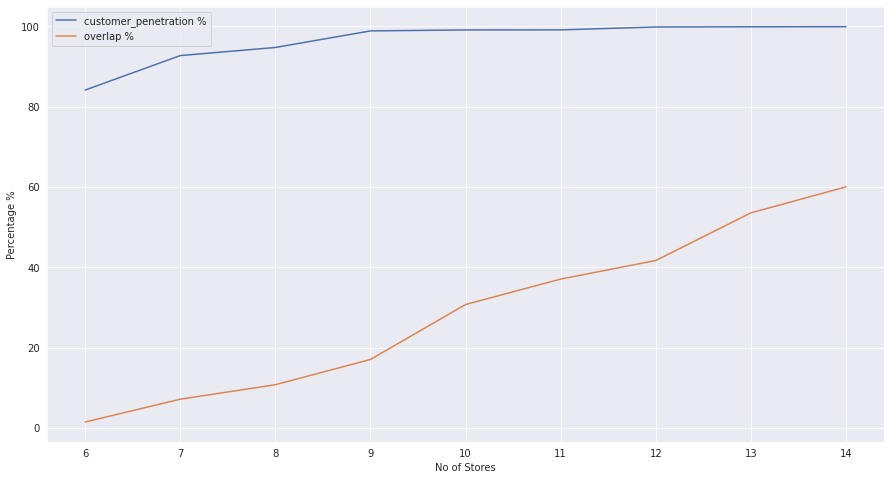

In [42]:
metric_df[metric_df.driving_time == 11][['customer_penetration %','overlap %']].plot()
plt.xlabel("No of Stores")
plt.ylabel("Percentage %")

KeyError: ignored

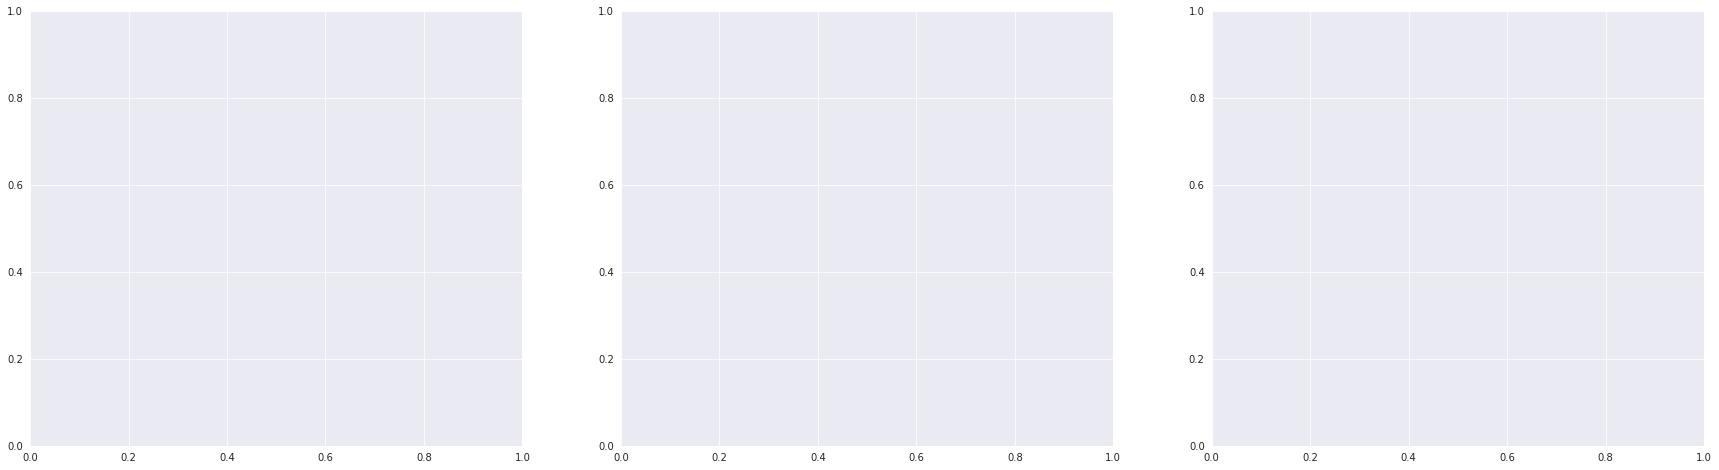

In [ ]:
  fig,ax = plt.subplots(1,3,figsize=(30,8))

  generate_stats_report(
      historical_outputs[11,7]['covered_per_actual_store'],
      historical_outputs[11,7]['covered_per_pred_store'],
      metrics,
      ax
      )

In [ ]:
# import json
# result = metric_df[metrics[1:]].T.to_json()
# parsed = json.loads(result)
# json.dumps(parsed)

In [ ]:
metric_df

In [ ]:

metrics = PARAMETERS['eval_metric']
fig,axes = plt.subplots(1,len(metrics),figsize=(30,8))
for num,ax in enumerate(zip(axes.flatten(),metrics)):
  ax[0].plot(metric_df[ax[1]])

  ax[0].set_title(f"{ax[1]} Score",fontsize = 15,fontweight='bold')
  ax[0].set_ylabel("Score",fontsize = 12,fontweight='bold')
  ax[0].set_xlabel("Num Of Clusters",fontsize = 12,fontweight='bold')

In [ ]:
metrics = PARAMETERS['eval_metric'][1:]
metrics

In [ ]:
  fig,ax = plt.subplots(1,3,figsize=(30,8))

  generate_stats_report(historical_outputs[(16,15)]['covered_per_actual_store'],historical_outputs[(16,15)]['covered_per_pred_store'],metrics[1:],ax)

In [ ]:
historical_outputs[(16,15)]['covered_per_actual_store'][metrics[1:]]


In [ ]:
historical_outputs[(16,15)]['covered_per_pred_store'][metrics[1:]]

In [ ]:
output

In [ ]:

pred['number_of_locations_covered'].sum() - actual['number_of_locations_covered'].sum()

In [ ]:
output = dict((df_pred[metrics] - df_actual[metrics]).sum())

In [ ]:
pred = historical_outputs[(16,15)]['covered_per_pred_store'][metrics[1:]]
pred['customer_density'] = np.round(pred['total_num_customers_coverage']/pred['number_of_locations_covered'])
pred['gmv_density'] = pred['total_gmv_coverage']/pred['number_of_locations_covered']
pred['order_density'] = pred['total_num_orders_coverage']/pred['number_of_locations_covered']

pred.sort_values(by='customer_density',ascending=False)

In [ ]:
actual = historical_outputs[(16,15)]['covered_per_actual_store'][metrics[1:]]
actual['customer_density'] = actual['total_num_customers_coverage']/actual['number_of_locations_covered']
actual.sort_values(by='customer_density',ascending=False)

In [ ]:
# metric_df

In [ ]:
# centers_ = covered_per_actual_store[covered_per_actual_store['number_of_locations_covered']!=0][['actual_lat','actual_long','actual_code']]
# ax[0].scatter(centers_['actual_long'], centers_['actual_lat'],c='white', s=500, alpha=0.9);

In [ ]:
# def generate_stats_report(covered_per_actual_store,covered_per_pred_store,metrics,ax):
#   df_actual = covered_per_actual_store[covered_per_actual_store['number_of_locations_covered']!=0]
#   df_pred = covered_per_pred_store[covered_per_pred_store['number_of_locations_covered']!=0]
#   print("Overlapping Stores[ACTUAL] with No excess coverage ->",covered_per_actual_store[covered_per_actual_store['number_of_locations_covered']==0].shape[0])
#   print("Overlapping Stores[PRED] with No excess coverage ->",covered_per_pred_store[covered_per_pred_store['number_of_locations_covered']==0].shape[0])

#   for ax,feature in zip(ax.flatten(),metrics):
#     sns.ecdfplot(df_pred[feature],ax=ax)
#     sns.ecdfplot(df_actual[feature],ax=ax)
#     ax.legend(['Pred Stores','Actual Stores'])
    
#   fig,ax = plt.subplots(1,2,figsize=(30,8))
#   for num,rows in covered_per_actual_store.iterrows():
#     # if num in [5,6,8]:
#       sns.scatterplot(
#           x = rows['latlong_list'][1],
#           y = rows['latlong_list'][0],
#           alpha = 0.4,
#           # c = rows['actual_code'][0],
#           ax=ax[0]
#       )
#       ax[0].text(rows['actual_long'],rows['actual_lat'],num,fontsize=12)


#   centers_ = covered_per_actual_store[covered_per_actual_store['number_of_locations_covered']!=0][['actual_lat','actual_long','actual_code']]
#   ax[0].scatter(centers_['actual_long'], centers_['actual_lat'],c='white', s=500, alpha=0.9);

#   centers_ = covered_per_actual_store[covered_per_actual_store['number_of_locations_covered']==0][['actual_lat','actual_long','actual_code']]
#   ax[0].scatter(centers_['actual_long'], centers_['actual_lat'],c='cyan', s=500, alpha=0.7);

#   ax[0].set_title(f'REGIONS COVERED in {time_} minutes [ACTUAL LOCATIONS]',fontsize=14, fontweight='bold')

#   for num,rows in covered_per_pred_store.iterrows():
#     # if num in [5,6,8]:
#       sns.scatterplot(

#           x = rows['latlong_list'][1],
#           y = rows['latlong_list'][0],
#           alpha = 0.4,
#           # c = rows['actual_code'][0],
#           ax=ax[1]
#       )
#       ax[1].text(rows['pred_long'],rows['pred_lat'],num,fontsize=12)


#   centers_ = covered_per_pred_store[covered_per_pred_store['number_of_locations_covered']!=0][['pred_lat','pred_long','pred_code']]
#   ax[1].scatter(centers_['pred_long'], centers_['pred_lat'],c='white', s=500, alpha=0.9);

#   centers_ = covered_per_pred_store[covered_per_pred_store['number_of_locations_covered']==0][['pred_lat','pred_long','pred_code']]
#   ax[1].scatter(centers_['pred_long'], centers_['pred_lat'],c='cyan', s=500, alpha=0.7);

#   ax[1].set_title(f'REGIONS COVERED in {time_} minutes [PRED LOCATIONS]',fontsize=14, fontweight='bold')
#   return ax

In [ ]:
  # fig,ax = plt.subplots(1,2,figsize=(30,8))
  # for num,rows in covered_per_actual_store.iterrows():
  #   # if num in [5,6,8]:
  #     sns.scatterplot(
  #         x = rows['latlong_list'][1],
  #         y = rows['latlong_list'][0],
  #         alpha = 0.4,
  #         # c = rows['actual_code'][0],
  #         ax=ax[0]
  #     )
  #     ax[0].text(rows['actual_long'],rows['actual_lat'],num,fontsize=12)


  # centers_ = covered_per_actual_store[covered_per_actual_store['number_of_locations_covered']!=0][['actual_lat','actual_long','actual_code']]
  # ax[0].scatter(centers_['actual_long'], centers_['actual_lat'],c='white', s=500, alpha=0.9);

  # centers_ = covered_per_actual_store[covered_per_actual_store['number_of_locations_covered']==0][['actual_lat','actual_long','actual_code']]
  # ax[0].scatter(centers_['actual_long'], centers_['actual_lat'],c='cyan', s=500, alpha=0.7);

  # ax[0].set_title(f'REGIONS COVERED in {time_} minutes [ACTUAL LOCATIONS]',fontsize=14, fontweight='bold')


In [ ]:
# output